In [1]:
import numpy as np
import matplotlib.pyplot as plt
import PIL
import os, cv2
import tensorflow as tf
from tqdm import tqdm
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Flatten, Reshape
from tensorflow.keras.models import Model
from skimage.util import random_noise
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [2]:
EPOCHS = 50
STEPS_PER_EPOCH = 15
NOISE_FACTOR = 0.2
IMAGE_HEIGHT, IMAGE_WIDTH = 256, 256
BATCH_SIZE = 16
VALIDATION_SPLIT = 0.2

In [3]:
# Définitions des répertoire 
PATH_MODEL_SAVE = './PATH_MODEL_SAVE'
PATH_DATASET ='../Dataset2'
PATH_GAUSSIAN_BLURRED = './Blurred_j'
PATH_GAUSSIAN_NOISED ='./Noisy_j'

if not os.path.exists(PATH_GAUSSIAN_BLURRED):
    os.mkdirs(PATH_GAUSSIAN_BLURRED)
    
if not os.path.exists(PATH_GAUSSIAN_NOISED):
    os.mkdirs(PATH_GAUSSIAN_NOISED)

In [4]:
# Fonction qui va afficher nos images 
def display_image(X, n):
    plt.figure(figsize = (32, 32))
    for i in range(n):
        ax = plt.subplot(1, n, i+1)
        plt.imshow(X[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [5]:
# Bruitage des images avec du bruit gaussien
images = os.listdir(PATH_DATASET)
def create_blurred_folder():
    for i, img in tqdm(enumerate(images), total = len(images)):
        img = cv2.imread(f"{PATH_DATASET}/{images[i]}")
        blur = cv2.GaussianBlur(img, (51, 51), 0)
        cv2.imwrite(f"{PATH_GAUSSIAN_BLURRED}/{images[i]}", blur)

if len(os.listdir(PATH_GAUSSIAN_BLURRED)) < len(images):
    create_blurred_folder()
else:
    print('Blur dataset ready !')


Blur dataset ready !


In [6]:
def create_noisy_images():
    for image_path in os.listdir(PATH_DATASET):
        input_path = os.path.join(PATH_DATASET, image_path).replace("\\", "/")
        img_to_noise = cv2.imread(input_path)
        noisy_image = random_noise(img_to_noise, mode='gaussian')
        noisy_image = np.array(255*noisy_image, dtype = 'uint8')
        cv2.imwrite(PATH_GAUSSIAN_NOISED + image_path, noisy_image)
        
if len(os.listdir(PATH_GAUSSIAN_NOISED)) < len(images):
    create_noisy_images()
else:
    print('Noisy dataset ready !')

Noisy dataset ready !


In [7]:
dataset_train = tf.keras.preprocessing.image_dataset_from_directory (
    PATH_DATASET,
    image_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
    validation_split = VALIDATION_SPLIT,
    batch_size = BATCH_SIZE,
    seed = 42,
    subset = 'training',
    color_mode = "rgb"
)

x_train, _ = iter(dataset_train).next()
x_train = x_train.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), IMAGE_WIDTH, IMAGE_HEIGHT, 3))

dataset_test = tf.keras.preprocessing.image_dataset_from_directory (
    PATH_DATASET,
    image_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
    validation_split = VALIDATION_SPLIT,
    batch_size = BATCH_SIZE,
    seed = 42,
    subset = 'validation',
    color_mode = "rgb"
)

x_test, _ = iter(dataset_test).next()
x_test = x_test.astype('float32') / 255.
x_test = np.reshape(x_test, (len(x_test), IMAGE_WIDTH, IMAGE_HEIGHT, 3))

Found 150 files belonging to 1 classes.
Using 120 files for training.
Found 150 files belonging to 1 classes.
Using 30 files for validation.


In [8]:
#Création des jeux de données bruités
dataset_train_noisy = tf.keras.preprocessing.image_dataset_from_directory (
    PATH_GAUSSIAN_NOISED ,
    labels = "inferred",
    label_mode = 'int',
    image_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
    validation_split = VALIDATION_SPLIT,
    batch_size = BATCH_SIZE,
    seed = 42,
    subset = 'training',
    color_mode = "rgb"
)

x_train_noisy, _ = iter(dataset_train_noisy).next()
x_train_noisy = x_train_noisy.astype('float32') / 255.
x_train_noisy = np.reshape(x_train_noisy, (len(x_train_noisy), IMAGE_WIDTH, IMAGE_HEIGHT, 3))

dataset_test_noisy = tf.keras.preprocessing.image_dataset_from_directory (
    PATH_GAUSSIAN_NOISED,
    labels = "inferred",
    label_mode = 'int',
    image_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
    validation_split = VALIDATION_SPLIT,
    batch_size = BATCH_SIZE,
    seed = 42,
    subset = 'validation',
    color_mode = "rgb"
)

x_test_noisy, _ = iter(dataset_test_noisy).next()
x_test_noisy = x_test_noisy.astype('float32') / 255.
x_test_noisy = np.reshape(x_test_noisy, (len(x_test_noisy), IMAGE_WIDTH, IMAGE_HEIGHT, 3))

Found 150 files belonging to 1 classes.
Using 120 files for training.
Found 150 files belonging to 1 classes.
Using 30 files for validation.


In [9]:
# Définition des jeux de test et validation

x_train_noisy = x_train + np.random.normal(loc = 0, scale = 1, size = x_train.shape)*NOISE_FACTOR
x_validation_noisy = x_test + np.random.normal(loc=0, scale = 1, size = x_test.shape)*NOISE_FACTOR

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_validation_noisy = np.clip(x_validation_noisy, 0., 1.)

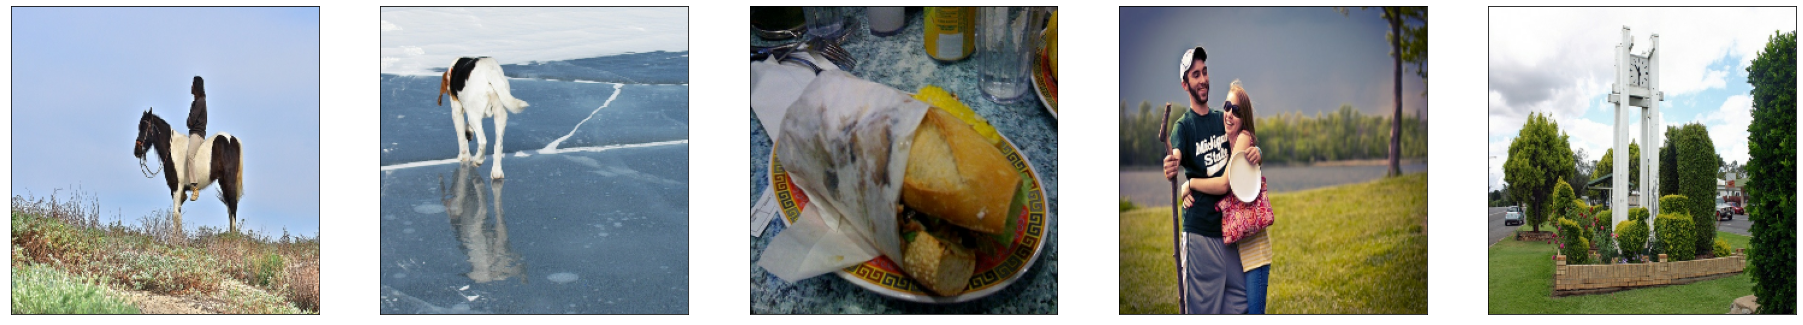

In [10]:
# On affiche les images normales 
display_image(x_train, n = 5)

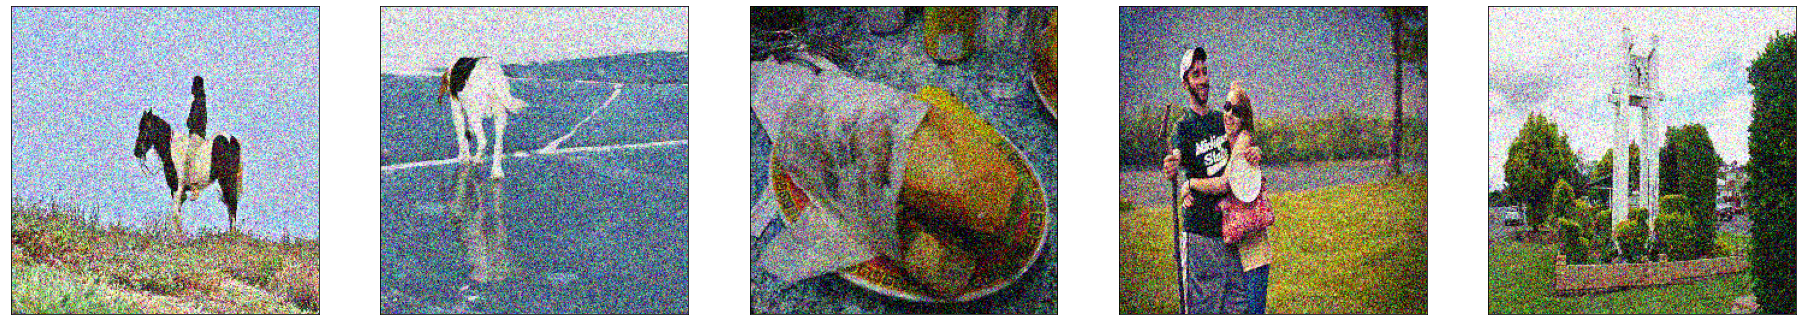

In [11]:
# On afficher les images bruitées 
display_image(x_train_noisy, n = 5)

In [12]:


INPUT_SHAPE = Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
# ENCODING
# Convolution 1
x = Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', name="conv_1_encoder")(INPUT_SHAPE)
x = MaxPooling2D((2, 2), padding="same", name="pooling_1")(x)

# Convolution 2
x = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', name="conv_2_encoder")(x)
x = MaxPooling2D((2, 2), padding="same", name="pooling_2")(x)

# Convolution 3
x = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu', name="conv_3_encoder")(x)
x = MaxPooling2D((2, 2), padding="same", name="pooling_3")(x)

# Convolution 4
x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', name="conv_4_encoder")(x)

encode = MaxPooling2D((2,2), padding="same", name="pooling_4")(x)

# DECODING
# Déconvolution 1
x = Conv2DTranspose(filters=256, kernel_size=3, strides=2, padding='same', activation='relu', name="conv_1_decoder")(encode)
#x = UpSampling2D((2, 2), name="sampling_1")(x)

# Déconvolution 2
x = Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same', activation='relu', name="conv_2_decoder")(x)
#x = UpSampling2D((2, 2), name="sampling_2")(x)

# Déconvolution 3
x = Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu', name="conv_3_decoder")(x)
#x = UpSampling2D((2, 2), name="sampling_3")(x)

# Déconvolution 4
x = Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu', name="conv_4_decoder")(x)
#x = UpSampling2D((2, 2), name="sampling_4")(x)
 
# Output    
decode = Conv2D(3, (3, 3),  padding="same", activation="sigmoid", name="output")(x)

In [13]:
#Définition de l'autoencoder et compilation du modèle 
autoencoder = Model(INPUT_SHAPE, decode, name="autoencoder")
autoencoder.compile(optimizer="adam", loss="mean_squared_error")
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv_1_encoder (Conv2D)     (None, 256, 256, 32)      896       
                                                                 
 pooling_1 (MaxPooling2D)    (None, 128, 128, 32)      0         
                                                                 
 conv_2_encoder (Conv2D)     (None, 128, 128, 64)      18496     
                                                                 
 pooling_2 (MaxPooling2D)    (None, 64, 64, 64)        0         
                                                                 
 conv_3_encoder (Conv2D)     (None, 64, 64, 128)       73856     
                                                                 
 pooling_3 (MaxPooling2D)    (None, 32, 32, 128)       

In [ ]:
#On entraine l'autoencoder
history = autoencoder.fit(x_train_noisy, x_train, epochs= EPOCHS, batch_size = BATCH_SIZE, 
                          steps_per_epoch = STEPS_PER_EPOCH, shuffle = True, validation_data = (x_test_noisy, x_test))

Epoch 1/50
15/15 [==============================] - 25s 2s/step - loss: 0.0763 - val_loss: 0.0630
Epoch 2/50
15/15 [==============================] - 29s 2s/step - loss: 0.0477 - val_loss: 0.0489
Epoch 3/50
15/15 [==============================] - 29s 2s/step - loss: 0.0274 - val_loss: 0.0419
Epoch 4/50
 1/15 [=>............................] - ETA: 30s - loss: 0.0245

In [ ]:
# On affiche les courbes loss du train et test 
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [ ]:
predictions = autoencoder.predict(x_test_noisy)
display_image(x_test, n=5)
display_image(x_test_noisy, n=5)
display_image(predictions, n=5)

In [ ]:
model_evaluation = autoencoder.evaluate(dataset_test_noisy)

In [ ]:
# On sauvegarde le modèle pour le réutiliser
autoencoder.save('PATH_MODEL_SAVE')
model = tf.keras.models.load_model(PATH_MODEL_SAVE)

In [ ]:
# On met l'image de test dans le bon format
input_img = PIL.Image.open('D:\CESI\A5\Data\Datasets\Test\images2.jpg').convert('RGB')
input_img = input_img.resize((256, 256), PIL.Image.ANTIALIAS)
input_img = np.array(input_img, dtype=np.float32)
input_img = input_img.astype('float32')/255
input_img = tf.expand_dims(input_img, axis=0)

In [ ]:
# Prédire une version débruité
denoised = model.predict(input_img)
display_image(denoised, n=1)